# Original Model

清洗数据，去掉大gamma，线性标准化，激活函数用relu，dropout 0.2

In [1]:
import pandas as pd
import numpy as np
import keras as kr
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
#from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
md_para = pd.read_csv('../data/substituted_benzene_para_md.csv',index_col=0,header=0)
md_orth = pd.read_csv('../data/substituted_benzene_orth_md.csv',index_col=0,header=0)
md_meta = pd.read_csv('../data/substituted_benzene_meta_md.csv',index_col=0,header=0)
mddata = pd.concat([md_meta,md_orth,md_para],axis=0,join='inner',ignore_index=True)

gammadata_meta = pd.read_csv('../data/substituted_benzene_meta_gamma.csv',index_col=0,header=0)
gammadata_orth = pd.read_csv('../data/substituted_benzene_orth_gamma.csv',index_col=0,header=0)
gammadata_para = pd.read_csv('../data/substituted_benzene_para_gamma.csv',index_col=0,header=0)
gammadata = pd.concat([gammadata_meta,gammadata_orth,gammadata_para],axis=0,join='inner',ignore_index=True)

In [3]:
def dfclean(data):
    temp = data[data.T[data.dtypes!=np.object].index]
    kk=[]
    for column in temp.columns:
        if len(set(temp[column]))<4:
            kk.append(column)
    result = temp.drop(columns=kk)
    return result

In [4]:
rawdataset = pd.merge(mddata, gammadata, on='cindex')
dataset = dfclean(rawdataset)

In [5]:
dataset = dataset[(dataset['magnitude_gamma'] < 22088)]

In [6]:
dataset = (dataset-dataset.min(axis=0))/(dataset.max(axis = 0)-dataset.min(axis=0))

In [7]:
Y = dataset.iloc[:, -1]
Y = np.array(Y, dtype = np.float32).reshape(-1,1)

In [8]:
X = dataset.iloc[:, 1:-1]
X = np.array(X, dtype = np.float32)

#Y= StandardScaler().fit_transform(Y)
#Y = (Y - min(Y))/(max(Y) - min(Y))
#Y = Y/max(Y)
#X= StandardScaler().fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)
model = Sequential()
model.add(Dense(units = 50, input_dim = X.shape[1]))
model.add(Activation("relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                47300     
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 47,351
Trainable params: 47,351
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss = 'mean_squared_error', optimizer = SGD(lr = 0.001, momentum = 0.9, nesterov = True),metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 200, batch_size = 10,validation_data = (X_test, y_test),verbose=0)
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
y_pred = model.predict(X_test)
rms = (np.mean((y_test - y_pred) ** 2)) ** 0.5
print("Neural Network RMS", rms)

Test loss: 0.018962260335683823
Test accuracy: 0.012345679104328156
Neural Network RMS 0.1377035300866647


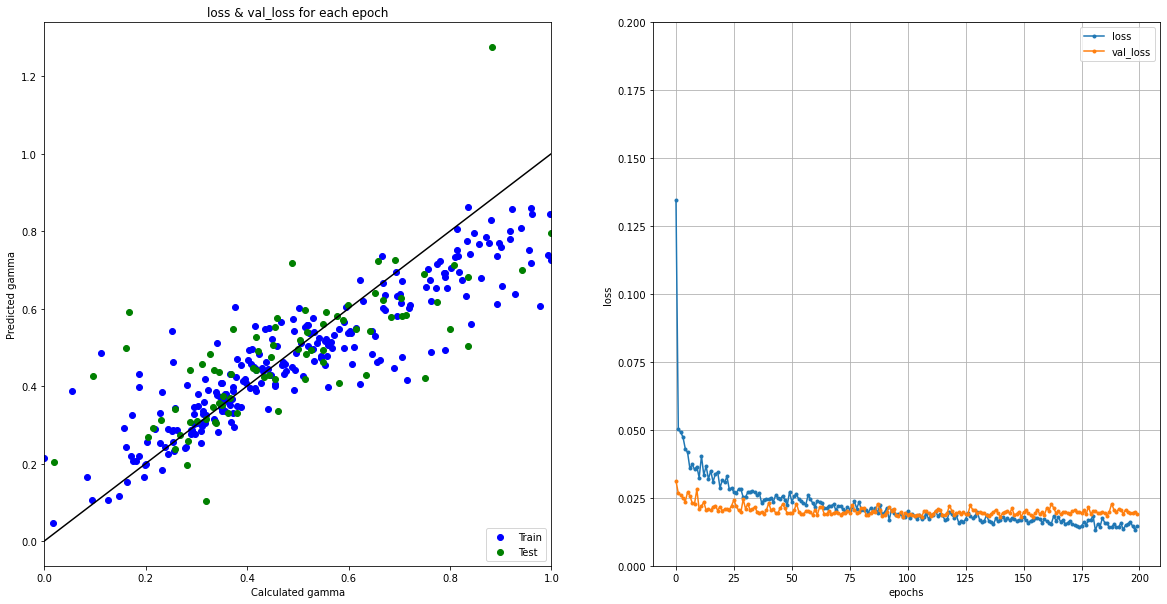

In [11]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(121)
ax1.set_title('Neural Network Predictor')
ax1.set_xlabel('Calculated gamma')
ax1.set_ylabel('Predicted gamma')
ax1.set_xlim(0,1)
#ax1.set_ylim(0,1)
ax1.scatter(y_train, model.predict(X_train), label = 'Train', c = 'blue')
ax1.scatter(y_test, model.predict(X_test),c='green', label = 'Test', alpha = None)
ax1.plot([0,1],[0,1],c = 'k')
ax1.legend(loc = 4)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)

ax2 = fig.add_subplot(122)
ax1.set_title('loss & val_loss for each epoch')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.set_ylim(0,0.2)
ax2.plot(range(epochs), loss, marker = '.', label = 'loss')
ax2.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
ax2.legend(loc = 'best')
ax2.grid()

plt.show()

## Conclusion

relu 的效果还不错